In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
import os

CUDA: True cuda:1


In [2]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = os.path.join('./data/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


In [3]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

In [5]:
graph_signal_matrix_filename = './data/PEMS04.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

load file: ./data/PEMS04_r1_d0_w0_astcgn
train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


In [6]:
id_filename = None
adj_filename = './data/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

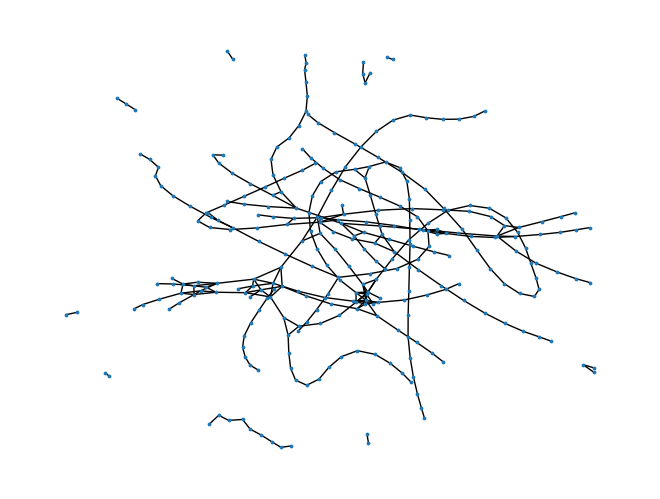

In [7]:
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

In [9]:
from torch_geometric_temporal.nn.attention import ASTGCN  

ModuleNotFoundError: No module named 'torch_geometric_temporal'